In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import euclidemu2 as ee2

In [2]:
def get_pks_from_file(run_name, redshift=0, test=False, ph_rev=False, out_ks=True):
    """
    Description: returns the linear and non-linear power spectra from COLA simulations at a given redshift. Optionally, return the COLA scales k.
    """
    ks, pk_nl, pk_lin = np.loadtxt(f"./a/output/{run_name}/pofk_{run_name}_total_z{redshift:.3f}.txt", unpack=True) if test else np.loadtxt(f"./a/output/{run_name}/pofk_run_{run_name}_total_z{redshift:.3f}.txt", unpack=True)    
    if ph_rev:
        pk_nl_2, pk_lin = np.loadtxt(f"./b/output/{run_name}ph_rev/pofk_{run_name}ph_rev_total_z{redshift:.3f}.txt", unpack=True, usecols=(1,2)) if test else np.loadtxt(f"./b/output/{run_name}ph_rev/pofk_run_{run_name}ph_rev_total_z{redshift:.3f}.txt", unpack=True, usecols=(1,2))
        pk_nl = (pk_nl + pk_nl)/2
    if out_ks:
        return ks, pk_nl, pk_lin
    return pk_nl, pk_lin

In [3]:
ks, pk_nl_ref, pk_lin_ref = get_pks_from_file("test_2", redshift=0, test=True, ph_rev=False, out_ks=True)

In [4]:
ref_params = {
    "h": 0.67,
    "Omm": 0.319,
    "Omb": 0.049,
    "As": 2.1e-9,
    "ns": 0.96,
    "w": -1,
    "wa": 0,
    "mnu": 0.058
}
ks, ref_boost_ee2 = ee2.get_boost(ref_params, [0], ks)

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.


In [5]:
lhs = np.loadtxt("lhs.txt")

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.


Text(0.5, 1.0, 'Test wCDM simulations')

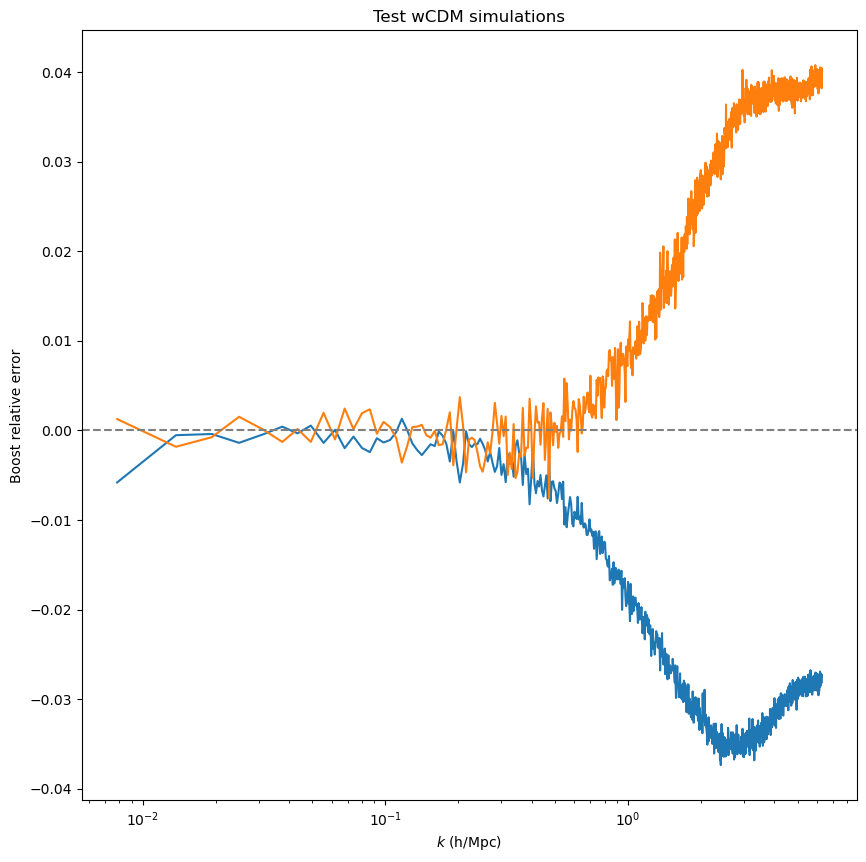

In [6]:
# Plot test boosts against EE2
ws = [-1.3, -0.7]
plt.figure(figsize=(10,10))
for i, w in enumerate(ws):
    params = {
        "h": 0.67,
        "Omm": 0.319,
        "Omb": 0.049,
        "As": 2.1e-9,
        "ns": 0.96,
        "w": w,
        "wa": 0,
        "mnu": 0.058
    }
    ks, boost_ee2 = ee2.get_boost(params, [0], ks)
    pk_nl, pk_lin = get_pks_from_file(f"test_{i}", test=True, ph_rev=False, out_ks=False)
    r_nl = pk_nl/pk_nl_ref
    r_lin = pk_lin/pk_lin_ref
    boost_cola = ref_boost_ee2[0] * r_nl/r_lin
    plt.semilogx(ks, boost_cola/boost_ee2[0] - 1)
plt.axhline(0, color='gray', ls='--')
plt.xlabel("$k$ (h/Mpc)")
plt.ylabel("Boost relative error")
plt.title("Test wCDM simulations")

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

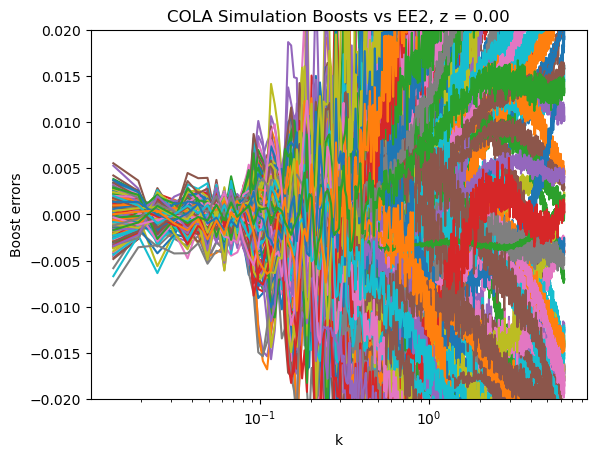

In [7]:
# Plot LHS boosts against EE2
plotted = 0
redshift = 0
ks, pk_nl_ref, pk_lin_ref = get_pks_from_file("test_2", redshift=redshift, test=True, ph_rev=False, out_ks=True)
issues = []
for i, sample in enumerate(lhs):
    if i in [474,475]:
        continue
    try:
        pk_nl, pk_lin = get_pks_from_file(f"{i}", redshift=redshift, ph_rev=False, out_ks=False)
    except Exception as err:
        print(f"Did not read cosmology {i}: {err}")
        continue
    params = {
        "h": sample[4],
        "Omm": sample[0],
        "Omb": sample[1],
        "As": sample[3],
        "ns": sample[2],
        "w": sample[5],
        "wa": 0,
        "mnu": 0.058
    }
    try:
        ks, boost_ee2 = ee2.get_boost(params,[redshift], ks)
    except Exception as err:
        # print(f"Cosmology {i} is outside the EE2 box.")
        continue
    r_nl = pk_nl/pk_nl_ref
    r_lin = pk_lin/pk_lin_ref
    boost_cola = ref_boost_ee2[redshift] * r_nl/r_lin
    errors = boost_cola/boost_ee2[0] - 1
    if abs(errors[0]) > 0.01:
        print(f"WARNING: Cosmology {i} has first bin error above 1%.")
        issues.append(i)
    plt.semilogx(ks[1:], errors[1:])
    plotted = plotted+1
# plt.ylim([-0.1, 0.1])
plt.ylim([-0.02, 0.02])
plt.xlabel("k")
plt.ylabel("Boost errors")
plt.title(f"COLA Simulation Boosts vs EE2, z = {redshift:.2f}")
# plt.savefig(f"results_z={redshift:.1f}.pdf", bbox_inches='tight')
print(f"Plotted {plotted} cosmologies")